In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
img_size = 128
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    "./PlantVillage",  # make sure notebook and PlantVillage are in same folder
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    "./PlantVillage",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

print("Classes found:", train_generator.class_indices)
print("Number of classes:", train_generator.num_classes)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Classes found: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}
Number of classes: 15


In [16]:
cnn_model = models.Sequential([
    layers.Input(shape=(img_size, img_size, 3)),  # use Input layer to avoid warnings
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(train_generator.num_classes, activation="softmax")  # 15 classes
])

cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
history_cnn = cnn_model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=10
)

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 233s 447ms/step - accuracy: 0.5682 - loss: 1.3263 - val_accuracy: 0.7072 - val_loss: 0.8980
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 126s 244ms/step - accuracy: 0.7831 - loss: 0.6427 - val_accuracy: 0.8365 - val_loss: 0.5023
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 122s 236ms/step - accuracy: 0.8341 - loss: 0.4888 - val_accuracy: 0.8326 - val_loss: 0.4829
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 121s 234ms/step - accuracy: 0.8635 - loss: 0.3954 - val_accuracy: 0.8447 - val_loss: 0.4613
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 232s 449ms/step - accuracy: 0.8831 - loss: 0.3433 - val_accuracy: 0.8780 - val_loss: 0.3603
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 325s 628ms/step - accuracy: 0.8993 - loss: 0.2994 - val_accuracy: 0.8957 - val_loss: 0.3082
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 136s 263ms/step - accuracy: 0.9111 - loss: 0.2571 - val_accuracy: 0.9115 - val_loss: 0.2585
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 251s 485ms/step - accuracy: 0.9203 -

In [18]:
val_loss, val_acc = cnn_model.evaluate(val_generator)
print("CNN Accuracy:", val_acc)

# Classification Report
y_true = val_generator.classes
y_pred = np.argmax(cnn_model.predict(val_generator), axis=1)
print("CNN Report:\n", classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

129/129 ━━━━━━━━━━━━━━━━━━━━ 24s 183ms/step - accuracy: 0.9025 - loss: 0.2995
CNN Accuracy: 0.9024745225906372
129/129 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step
CNN Report:
                                              precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.04      0.04      0.04       199
                     Pepper__bell___healthy       0.05      0.05      0.05       295
                      Potato___Early_blight       0.06      0.06      0.06       200
                       Potato___Late_blight       0.04      0.04      0.04       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.12      0.14      0.13       425
                        Tomato_Early_blight       0.07      0.06      0.06       200
                         Tomato_Late_blight       0.10      0.12      0.11       381
                           Tomato_Leaf_Mold       0.06      0.05  

In [19]:
y_pred = []
y_true = []

val_generator.reset()  # reset generator to start from beginning

for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]       # get batch
    y_true.extend(np.argmax(y_batch, axis=1)) # true labels
    y_pred.extend(np.argmax(cnn_model.predict(x_batch), axis=1)) # predicted labels

y_true = np.array(y_true)
y_pred = np.array(y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━

In [21]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # freeze base layers

tl_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(train_generator.num_classes, activation="softmax")
])

tl_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history_tl = tl_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 739s 1s/step - accuracy: 0.7774 - loss: 0.6956 - val_accuracy: 0.8418 - val_loss: 0.4781
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 275s 533ms/step - accuracy: 0.8619 - loss: 0.4160 - val_accuracy: 0.8583 - val_loss: 0.4227
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 257s 496ms/step - accuracy: 0.8797 - loss: 0.3574 - val_accuracy: 0.8816 - val_loss: 0.3609
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 254s 492ms/step - accuracy: 0.8934 - loss: 0.3203 - val_accuracy: 0.8724 - val_loss: 0.3704
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 152s 293ms/step - accuracy: 0.8996 - loss: 0.2900 - val_accuracy: 0.8882 - val_loss: 0.3263
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 653s 1s/step - accuracy: 0.9068 - loss: 0.2712 - val_accuracy: 0.8860 - val_loss: 0.3317
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 119s 231ms/step - accuracy: 0.9116 - loss: 0.2518 - val_accuracy: 0.8908 - val_loss: 0.3088
Epoch 8/10
517/517 ━━━━━━━━━━━━━━

In [25]:
def evaluate_model(model, generator, classes, model_name="Model"):
    val_loss, val_acc = model.evaluate(generator)
    print(f"{model_name} Accuracy: {val_acc:.4f}")
    
    # Predict
    y_true = generator.classes
    y_pred = np.argmax(model.predict(generator), axis=1)
    
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=classes))

# Define the classes list
classes = list(train_generator.class_indices.keys())

# Pass 'classes' explicitly
evaluate_model(cnn_model, val_generator, classes, "CNN Model")
evaluate_model(tl_model, val_generator, classes, "Transfer Learning Model")

129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.9037 - loss: 0.2780
CNN Model Accuracy: 0.9037
129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step

CNN Model Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.07      0.07      0.07       199
                     Pepper__bell___healthy       0.06      0.06      0.06       295
                      Potato___Early_blight       0.04      0.04      0.04       200
                       Potato___Late_blight       0.03      0.03      0.03       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.11      0.13      0.12       425
                        Tomato_Early_blight       0.02      0.01      0.02       200
                         Tomato_Late_blight       0.09      0.10      0.09       381
                           Tomato_Leaf_Mold       

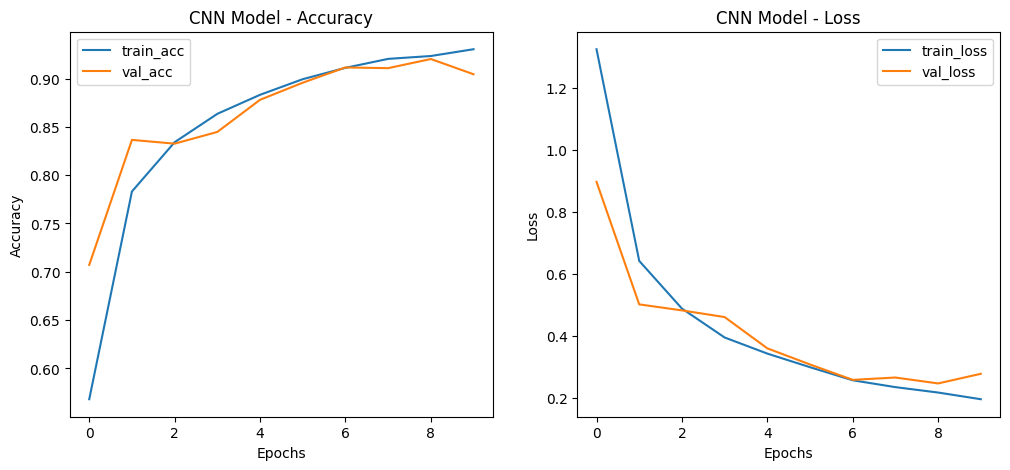

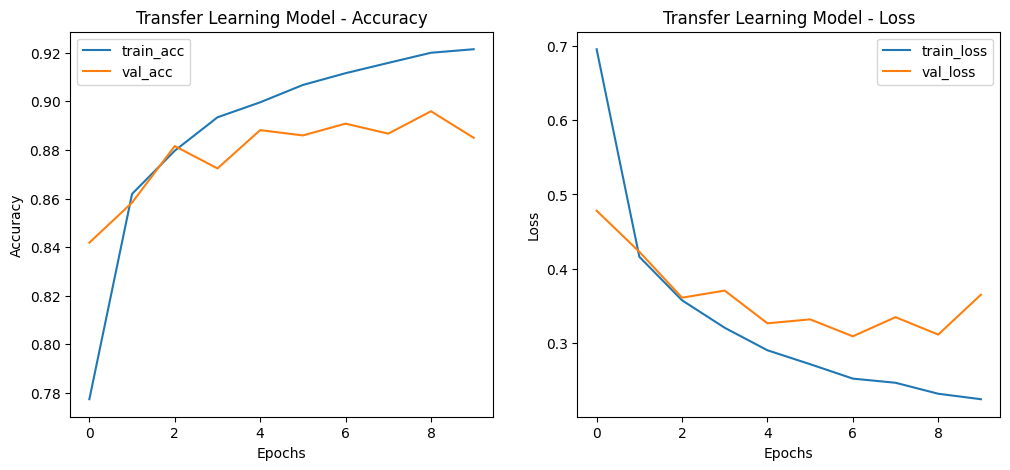

In [26]:
def plot_history(history, title="Model History"):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_cnn, "CNN Model")
plot_history(history_tl, "Transfer Learning Model")

129/129 ━━━━━━━━━━━━━━━━━━━━ 115s 894ms/step


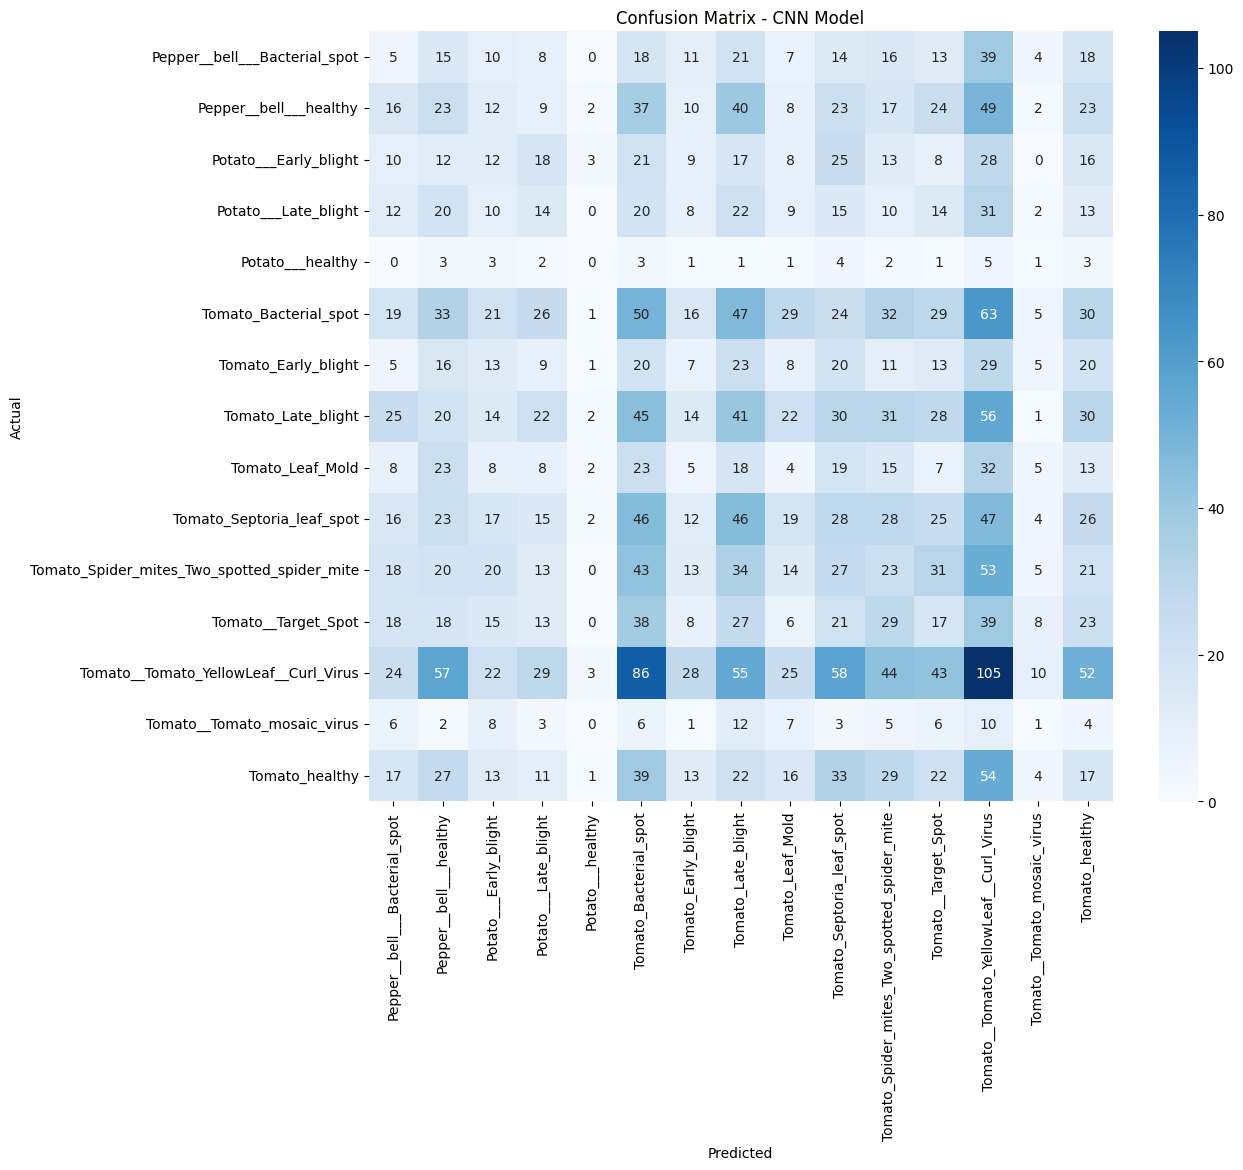

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true and predicted labels
y_true = val_generator.classes
y_pred = np.argmax(cnn_model.predict(val_generator), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN Model')
plt.show()

129/129 ━━━━━━━━━━━━━━━━━━━━ 25s 191ms/step


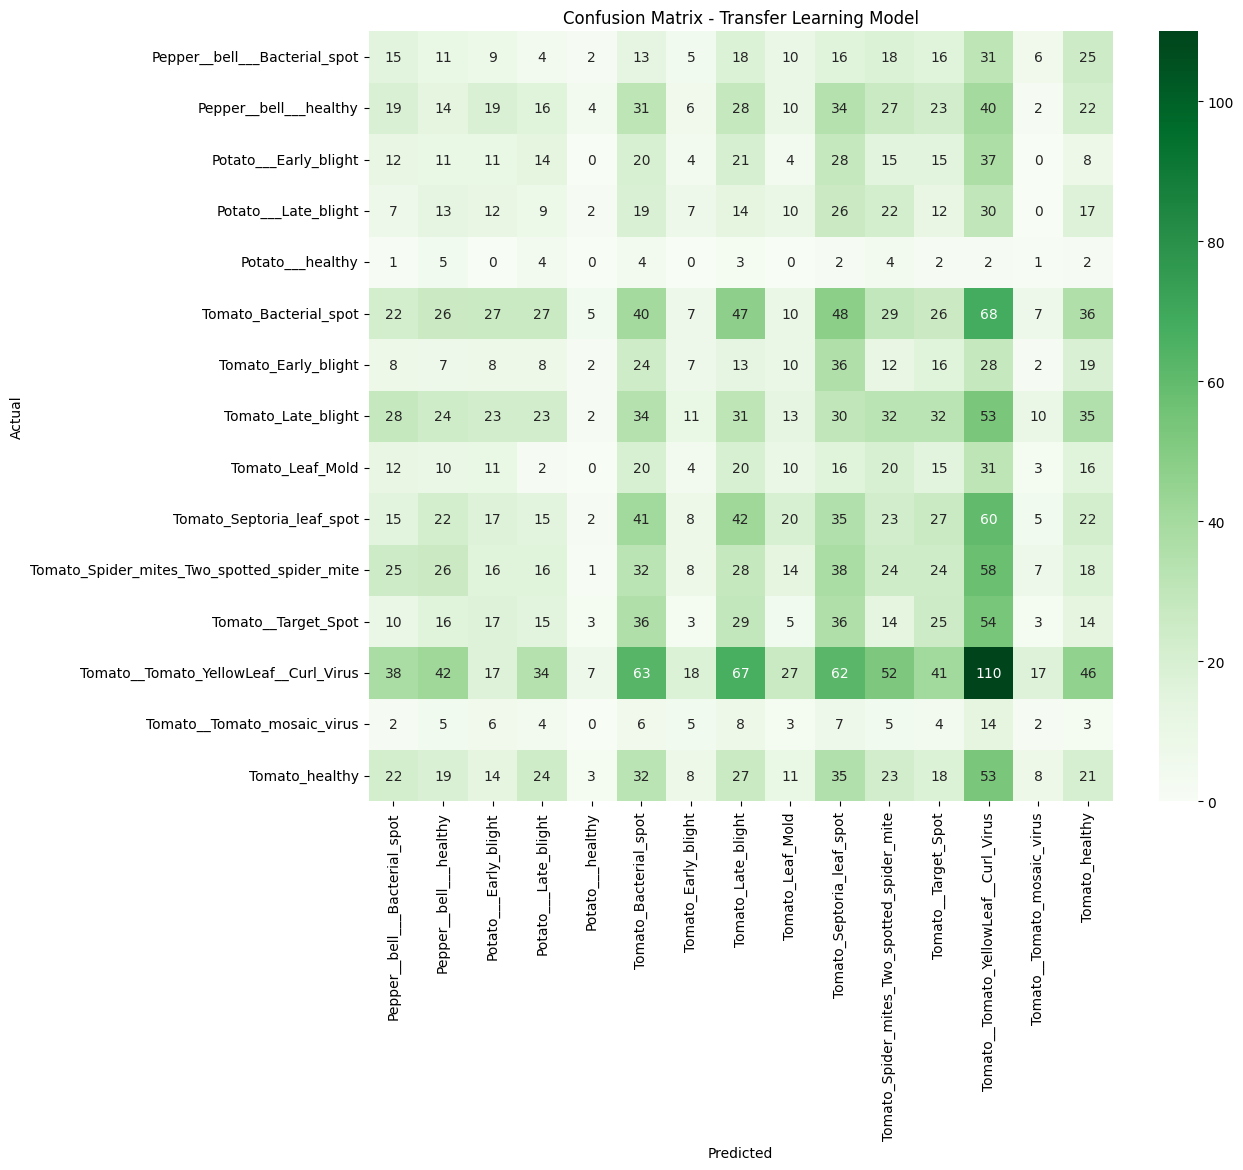

In [28]:
# For Transfer Learning Model
y_true = val_generator.classes
y_pred = np.argmax(tl_model.predict(val_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Transfer Learning Model')
plt.show()